# 🎬 PhoBERT - 3-Class Sentiment Classification
**Labels**: Negative (0), Neutral (1), Positive (2)

In [ ]:
!pip install transformers accelerate -q

In [1]:
import json, numpy as np, pandas as pd
from datetime import datetime
import torch, torch.nn as nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2025-12-29 16:32:53.600516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767025973.785680      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767025973.835194      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch: 2.6.0+cu124, CUDA: True
GPU: Tesla T4


In [2]:
CONFIG = {'model': 'vinai/phobert-base', 'max_len': 256, 'batch': 16, 'epochs': 5, 'lr': 2e-5, 'seed': 42}
LABELS = ['Negative', 'Neutral', 'Positive']
torch.manual_seed(CONFIG['seed']); np.random.seed(CONFIG['seed'])

In [3]:
# Load data - UPDATE PATH
DATA_PATH = '/kaggle/input/movie-emotion-rate/labeled_reviews.csv'
df = pd.read_csv(DATA_PATH)
text_col = 'processed_text' if 'processed_text' in df.columns else 'review_text'
df = df[df[text_col].notna() & df['final_label'].notna()]
texts, labels = df[text_col].tolist(), df['final_label'].astype(int).tolist()
print(f"Samples: {len(texts)}")
for i,n in enumerate(LABELS): print(f"  {n}: {labels.count(i)} ({labels.count(i)/len(labels)*100:.1f}%)")

Samples: 3424
  Negative: 383 (11.2%)
  Neutral: 241 (7.0%)
  Positive: 2800 (81.8%)


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32).to(device)
print(f"Weights: {dict(zip(LABELS, class_weights.cpu().numpy()))}")

Train: 2396, Val: 514, Test: 514
Weights: {'Negative': 2.9800994, 'Neutral': 4.725838, 'Positive': 0.407691}


In [5]:
class DS(Dataset):
    def __init__(s,t,l,tok,ml): s.t,s.l,s.tok,s.ml=t,l,tok,ml
    def __len__(s): return len(s.t)
    def __getitem__(s,i):
        e=s.tok(str(s.t[i]),truncation=True,max_length=s.ml,padding='max_length',return_tensors='pt')
        return {'input_ids':e['input_ids'].squeeze(),'attention_mask':e['attention_mask'].squeeze(),'labels':torch.tensor(s.l[i],dtype=torch.long)}

class WT(Trainer):
    def __init__(s,w,*a,**k): super().__init__(*a,**k); s.w=w
    def compute_loss(s,m,inp,return_outputs=False,**k):
        l=inp.pop('labels'); o=m(**inp)
        loss=nn.CrossEntropyLoss(weight=s.w)(o.logits,l)
        return (loss,o) if return_outputs else loss

In [6]:
print(f"Loading {CONFIG['model']}...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model'])
model = AutoModelForSequenceClassification.from_pretrained(CONFIG['model'], num_labels=3).to(device)
print("✓ Model loaded")

train_ds = DS(X_train, y_train, tokenizer, CONFIG['max_len'])
val_ds = DS(X_val, y_val, tokenizer, CONFIG['max_len'])
test_ds = DS(X_test, y_test, tokenizer, CONFIG['max_len'])

Loading vinai/phobert-base...


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [7]:
def metrics(p):
    pred=np.argmax(p.predictions,axis=1)
    acc=accuracy_score(p.label_ids,pred)
    _,_,f1,_=precision_recall_fscore_support(p.label_ids,pred,average='macro',zero_division=0)
    f1w=precision_recall_fscore_support(p.label_ids,pred,average='weighted',zero_division=0)[2]
    return {'accuracy':acc,'f1_macro':f1,'f1_weighted':f1w}

args = TrainingArguments(
    output_dir='./ckpt', num_train_epochs=CONFIG['epochs'],
    per_device_train_batch_size=CONFIG['batch'], per_device_eval_batch_size=32,
    warmup_ratio=0.1, weight_decay=0.01, learning_rate=CONFIG['lr'],
    logging_steps=50, eval_strategy='epoch', save_strategy='epoch',
    load_best_model_at_end=True, metric_for_best_model='f1_macro',
    save_total_limit=2, report_to='none', seed=CONFIG['seed'], fp16=torch.cuda.is_available()
)

trainer = WT(class_weights, model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds,
    tokenizer=tokenizer, data_collator=DataCollatorWithPadding(tokenizer), compute_metrics=metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])
print("✓ Ready")

✓ Ready


/tmp/ipykernel_47/3610607626.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WT.__init__`. Use `processing_class` instead.
  def __init__(s,w,*a,**k): super().__init__(*a,**k); s.w=w


In [8]:
print("="*60 + "\n🚀 TRAINING\n" + "="*60)
trainer.train()

🚀 TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.097000,0.966734,0.782101,0.584014,0.808882
2,0.793900,0.704802,0.856031,0.653703,0.863907
3,0.662700,0.648425,0.869650,0.699050,0.880234
4,0.551400,0.653021,0.861868,0.695561,0.876076
5,0.484900,0.654736,0.861868,0.671288,0.873110


TrainOutput(global_step=375, training_loss=0.7130571060180664, metrics={'train_runtime': 331.6679, 'train_samples_per_second': 36.12, 'train_steps_per_second': 1.131, 'total_flos': 1576049372190720.0, 'train_loss': 0.7130571060180664, 'epoch': 5.0})

In [9]:
print("="*60 + "\nEVALUATION\n" + "="*60)
res = trainer.evaluate(test_ds)
for k,v in res.items():
    if isinstance(v,float): print(f"  {k}: {v:.4f}")

pred = np.argmax(trainer.predict(test_ds).predictions, axis=1)
print("\n" + classification_report(y_test, pred, target_names=LABELS, digits=4))

EVALUATION


  eval_loss: 0.7597
  eval_accuracy: 0.8171
  eval_f1_macro: 0.6053
  eval_f1_weighted: 0.8395
  eval_runtime: 3.9058
  eval_samples_per_second: 131.5990
  eval_steps_per_second: 2.3040
  epoch: 5.0000

              precision    recall  f1-score   support

    Negative     0.5909    0.6724    0.6290        58
     Neutral     0.2059    0.3889    0.2692        36
    Positive     0.9658    0.8738    0.9175       420

    accuracy                         0.8171       514
   macro avg     0.5875    0.6450    0.6053       514
weighted avg     0.8703    0.8171    0.8395       514



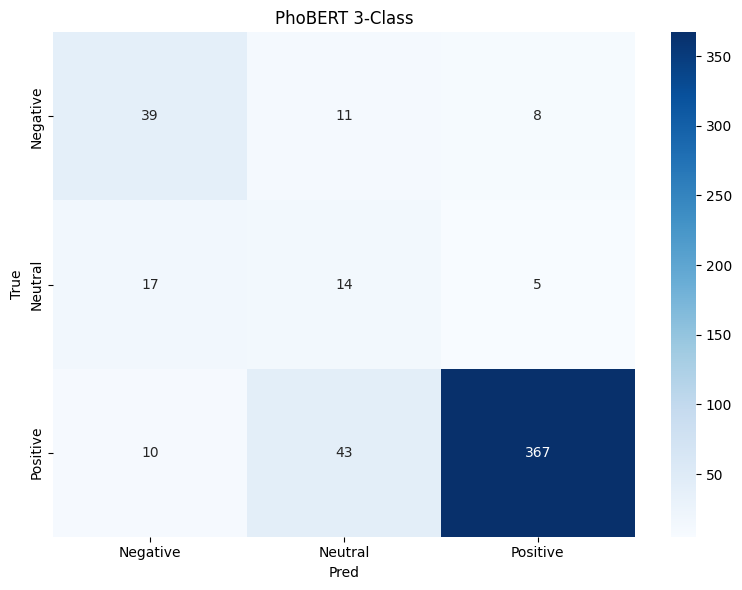

In [10]:
import matplotlib.pyplot as plt, seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.title('PhoBERT 3-Class'); plt.ylabel('True'); plt.xlabel('Pred')
plt.tight_layout(); plt.savefig('confusion_matrix.png', dpi=150); plt.show()

In [11]:
results = {
    'timestamp': datetime.now().isoformat(), 'model': CONFIG['model'], 'num_classes': 3,
    'test_metrics': {k.replace('eval_',''):float(v) for k,v in res.items() if isinstance(v,float)},
    'classification_report': classification_report(y_test, pred, target_names=LABELS, output_dict=True),
    'confusion_matrix': cm.tolist()
}
with open('phobert_3class_results.json', 'w') as f: json.dump(results, f, indent=2)
print(f"\n🎉 Accuracy: {res['eval_accuracy']:.4f}, F1-macro: {res['eval_f1_macro']:.4f}")
print("📥 Download: phobert_3class_results.json, confusion_matrix.png")


🎉 Accuracy: 0.8171, F1-macro: 0.6053
📥 Download: phobert_3class_results.json, confusion_matrix.png
